In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
#To coverup class imbalance in my selected dataset:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
#TO improve accuracy
from sklearn.ensemble import VotingClassifier

In [2]:
# Load the dataset
file_path = './dataset/doctors_dataset.csv'
doctors_data = pd.read_csv(file_path)

# Display initial dataset
print("Initial Dataset:")
print(doctors_data.head())

# Step 1: Handle Missing Values
# Fill numerical missing values with mean and categorical with mode
for column in doctors_data.columns:
    if doctors_data[column].dtype in ['float64', 'int64']:
        doctors_data[column].fillna(doctors_data[column].mean(), inplace=True)
    else:
        doctors_data[column].fillna(doctors_data[column].mode()[0], inplace=True)

print("\nDataset After Handling Missing Values:")
print(doctors_data.isnull().sum())

# Step 2: Normalize Numerical Data
# Select numerical columns for normalization
numerical_columns = ['Experience(Years)', 'Total_Reviews', 'Patient Satisfaction Rate(%age)',
                     'Avg Time to Patients(mins)', 'Wait Time(mins)', 'Fee(PKR)']

scaler = MinMaxScaler()
doctors_data[numerical_columns] = scaler.fit_transform(doctors_data[numerical_columns])

print("\nDataset After Normalization:")
print(doctors_data[numerical_columns].head())

# Save preprocessed data to a new CSV (optional)
doctors_data.to_csv('./dataset/preprocessed_doctors_dataset.csv', index=False)
print("\nPreprocessed data saved to './dataset/preprocessed_doctors_dataset.csv'.")


Initial Dataset:
                        Doctor Name    City                   Specialization  \
0         Prof. Dr. Syed Shamsuddin  QUETTA                    Dermatologist   
1                    Dr. Jaffar Ali  QUETTA                    Dermatologist   
2  Asst. Prof. Dr. Syed Bilal Shams  QUETTA  Dermatologist, Cosmetic Surgeon   
3     Asst. Prof. Dr. Surjeet Kumar  QUETTA                    Dermatologist   
4                Dr. Palwasha Jalil  QUETTA                    Dermatologist   

                                Doctor Qualification  Experience(Years)  \
0                                   MBBS, MCPS, FCPS               30.0   
1            MBBS, MCPS (Dermatology), FDV (Austria)               32.0   
2  MBBS, FCPS (Dermatology), Fellowship In Dermat...               15.0   
3                            MBBS, FCPS(Dermatology)               12.0   
4      MBBS, FCPS (Dermatology) Agha Khan University                8.0   

   Total_Reviews  Patient Satisfaction Rate(%age)  

Correlation Matrix:
                                 Experience(Years)  Total_Reviews  \
Experience(Years)                         1.000000       0.306664   
Total_Reviews                             0.306664       1.000000   
Patient Satisfaction Rate(%age)          -0.029731       0.022066   
Avg Time to Patients(mins)                0.050042       0.061254   
Wait Time(mins)                           0.092121       0.134416   
Fee(PKR)                                  0.440698       0.321154   

                                 Patient Satisfaction Rate(%age)  \
Experience(Years)                                      -0.029731   
Total_Reviews                                           0.022066   
Patient Satisfaction Rate(%age)                         1.000000   
Avg Time to Patients(mins)                             -0.005410   
Wait Time(mins)                                        -0.014164   
Fee(PKR)                                                0.024594   

                   

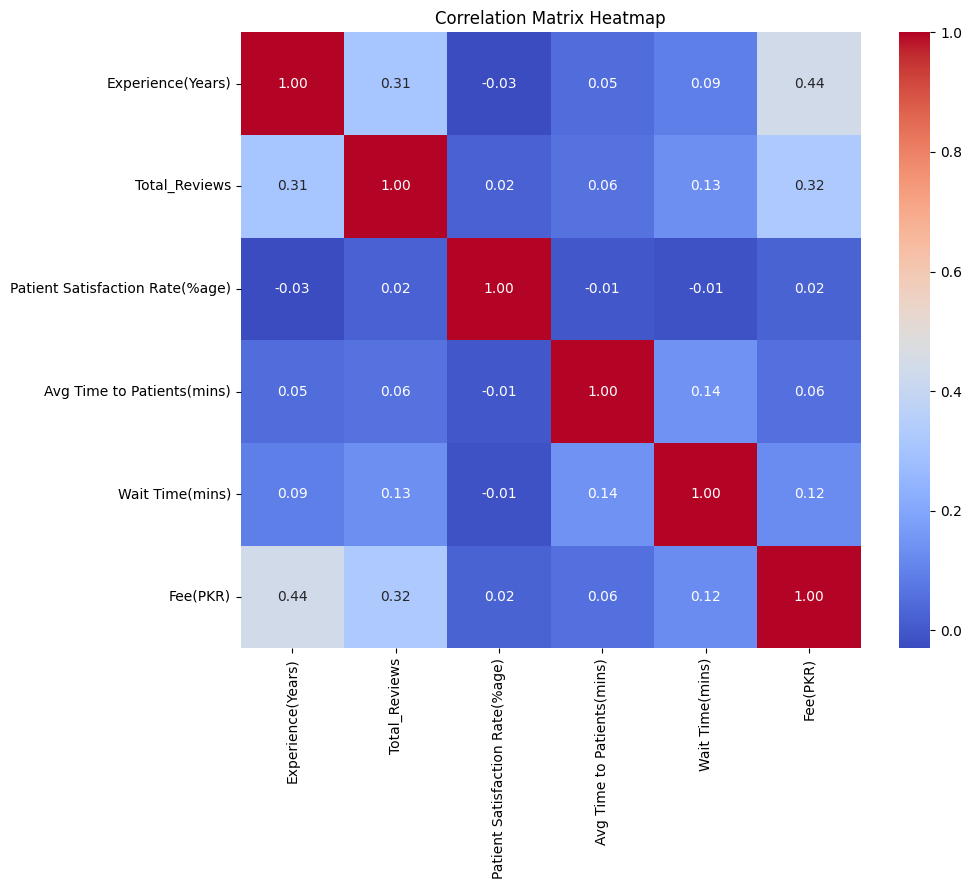


Selected Features:
Index(['Experience(Years)', 'Fee(PKR)', 'Total_Reviews', 'Wait Time(mins)',
       'Avg Time to Patients(mins)'],
      dtype='object')


In [3]:
# Ensure only numerical columns are used for correlation
numerical_columns = ['Experience(Years)', 'Total_Reviews', 'Patient Satisfaction Rate(%age)',
                     'Avg Time to Patients(mins)', 'Wait Time(mins)', 'Fee(PKR)']

# Retain only numerical columns for correlation
numerical_data = doctors_data[numerical_columns]  # Changed 'data' to 'doctors_data'

# Step 2: Feature Selection
# Calculate correlations
correlation_matrix = numerical_data.corr()
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

# Select top features based on correlation with target variable
target = 'Patient Satisfaction Rate(%age)'
selected_features = correlation_matrix[target].abs().sort_values(ascending=False).index[1:6]  # Top 5 features
print("\nSelected Features:")
print(selected_features)

In [4]:
# Define the target variable and features
X = doctors_data[selected_features]  # Changed from data to doctors_data
y = (doctors_data['Patient Satisfaction Rate(%age)'] > 0.9).astype(int)  # Changed from data to doctors_data

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Original class distribution: {y_train.value_counts().to_dict()}")
print(f"Balanced class distribution after SMOTE: {pd.Series(y_train_smote).value_counts().to_dict()}")

# Update model definitions to include class weights
models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced'),
    "RandomForest": RandomForestClassifier(class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "SVM": SVC(probability=True, class_weight='balanced'),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(class_weight='balanced'),
    "NaiveBayes": GaussianNB(),
    "AdaBoost": AdaBoostClassifier()
}

# Re-train models with balanced class weights and evaluate
best_models = {}
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    param_grid = {
        "LogisticRegression": {"C": [0.1, 1, 10]},
        "RandomForest": {"n_estimators": [50, 100, 200]},
        "XGBoost": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]},
        "SVM": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
        "KNN": {"n_neighbors": [3, 5, 7]},
        "DecisionTree": {"max_depth": [3, 5, 10]},
        "NaiveBayes": {},  # No hyperparameters to tune
        "AdaBoost": {"n_estimators": [50, 100, 200]}
    }.get(model_name, {})

    grid_search = GridSearchCV(model, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
    grid_search.fit(X_train_smote, y_train_smote)  # Use SMOTE balanced data
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Evaluate the model
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {model_name}: {acc * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

Original class distribution: {1: 1980, 0: 141}
Balanced class distribution after SMOTE: {1: 1980, 0: 1980}

Training LogisticRegression...
Accuracy of LogisticRegression: 58.76%

Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.48      0.13        33
           1       0.95      0.59      0.73       498

    accuracy                           0.59       531
   macro avg       0.51      0.54      0.43       531
weighted avg       0.89      0.59      0.69       531

Confusion Matrix:
[[ 16  17]
 [202 296]]

Training RandomForest...
Accuracy of RandomForest: 90.58%

Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.24      0.24        33
           1       0.95      0.95      0.95       498

    accuracy                           0.91       531
   macro avg       0.60      0.60      0.60       531
weighted avg       0.91      0.91      0.91       531

Confusion Matrix:
[[

c:\Users\usama\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:54:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy of XGBoost: 90.96%

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.15      0.17        33
           1       0.94      0.96      0.95       498

    accuracy                           0.91       531
   macro avg       0.57      0.56      0.56       531
weighted avg       0.90      0.91      0.90       531

Confusion Matrix:
[[  5  28]
 [ 20 478]]

Training SVM...
Accuracy of SVM: 72.32%

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.36      0.14        33
           1       0.95      0.75      0.84       498

    accuracy                           0.72       531
   macro avg       0.52      0.56      0.49       531
weighted avg       0.89      0.72      0.79       531

Confusion Matrix:
[[ 12  21]
 [126 372]]

Training KNN...
Accuracy of KNN: 76.27%

Classification Report:
              precision    recall  f1-score   support

           0       0.07    


Evaluating LogisticRegression...
Accuracy: 58.76%
Precision: 0.95
Recall: 0.59
F1 Score: 0.73
ROC-AUC: 0.5667822806377023


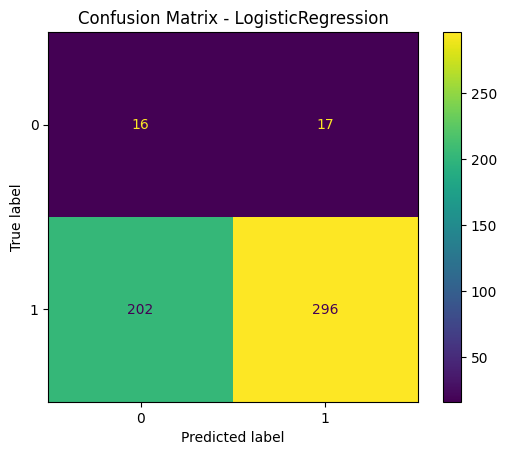

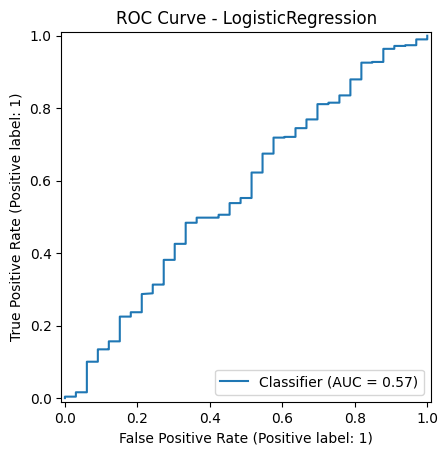


Evaluating RandomForest...
Accuracy: 90.58%
Precision: 0.95
Recall: 0.95
F1 Score: 0.95
ROC-AUC: 0.735426554703663


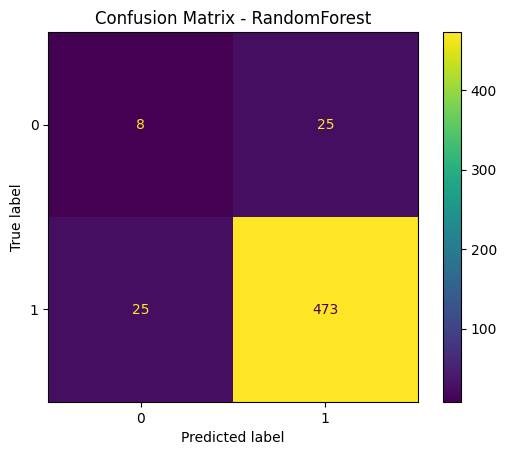

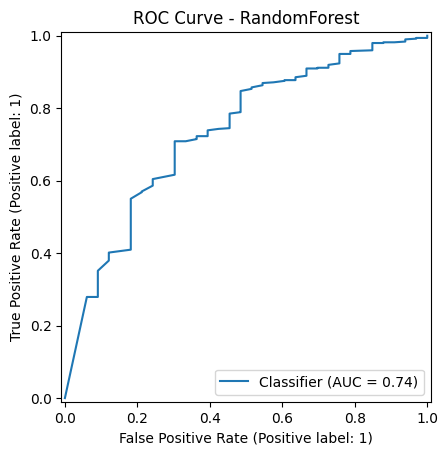


Evaluating XGBoost...
Accuracy: 90.96%
Precision: 0.94
Recall: 0.96
F1 Score: 0.95
ROC-AUC: 0.7725142996227334


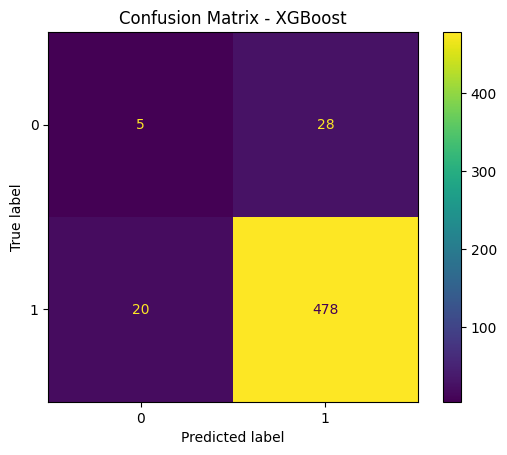

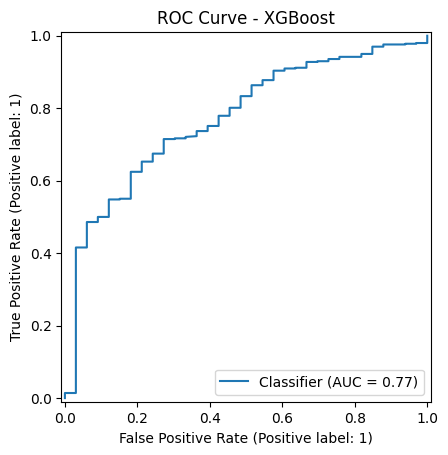


Evaluating SVM...
Accuracy: 72.32%
Precision: 0.95
Recall: 0.75
F1 Score: 0.84
ROC-AUC: 0.6031702567847147


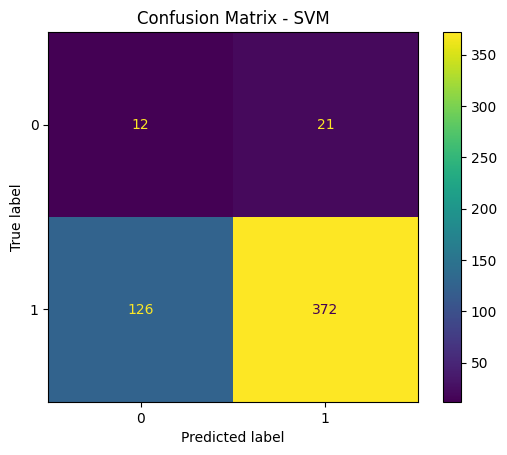

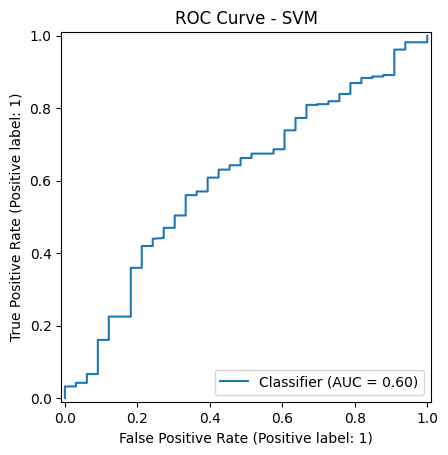


Evaluating KNN...
Accuracy: 76.27%
Precision: 0.94
Recall: 0.80
F1 Score: 0.86
ROC-AUC: 0.5284166970913959


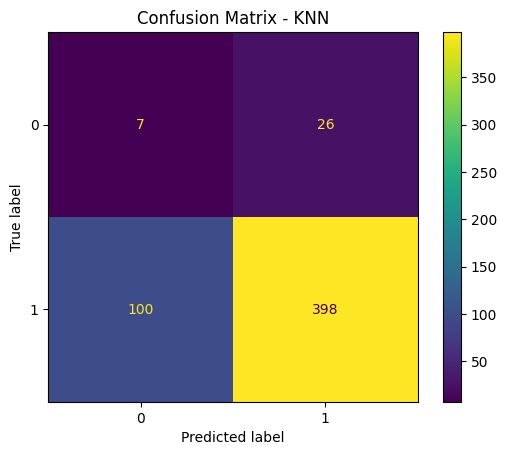

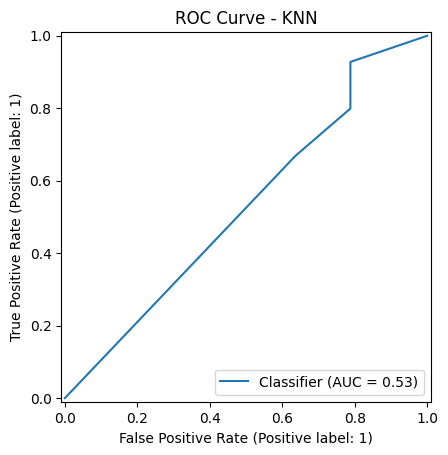


Evaluating DecisionTree...
Accuracy: 79.66%
Precision: 0.95
Recall: 0.83
F1 Score: 0.88
ROC-AUC: 0.6035049288061336


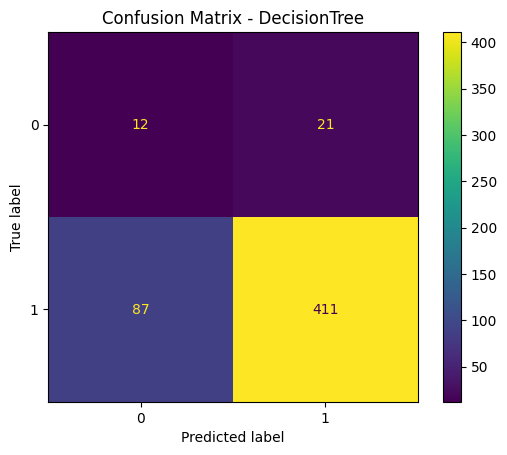

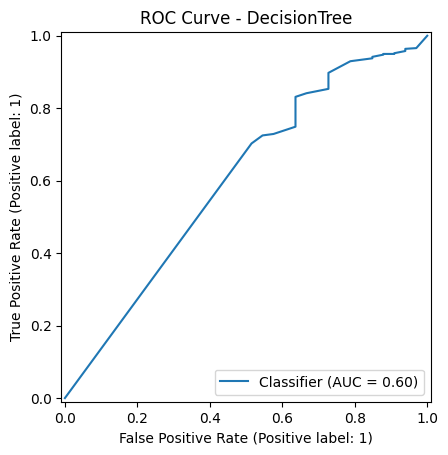


Evaluating NaiveBayes...
Accuracy: 63.09%
Precision: 0.95
Recall: 0.64
F1 Score: 0.76
ROC-AUC: 0.5259827187538031


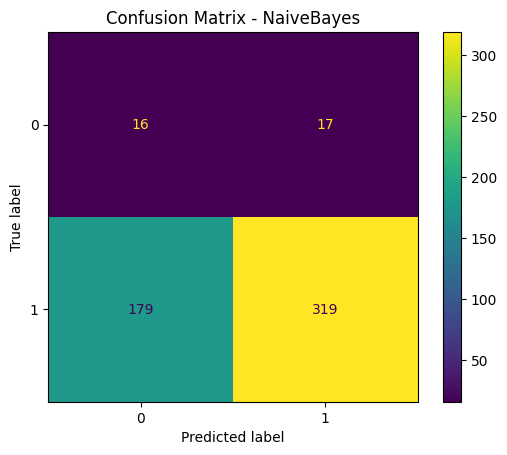

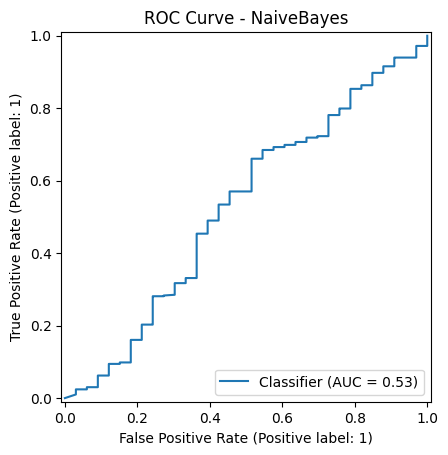


Evaluating AdaBoost...
Accuracy: 77.21%
Precision: 0.96
Recall: 0.79
F1 Score: 0.87
ROC-AUC: 0.7437325057806986


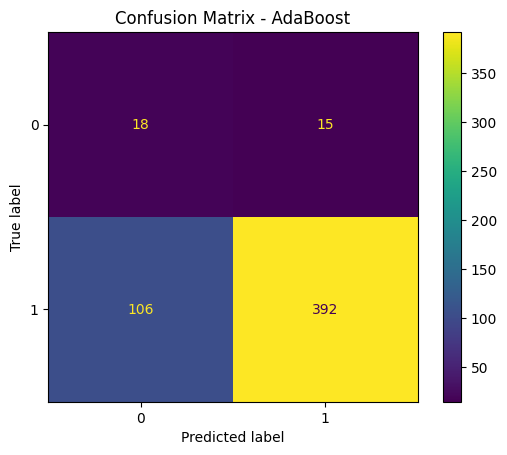

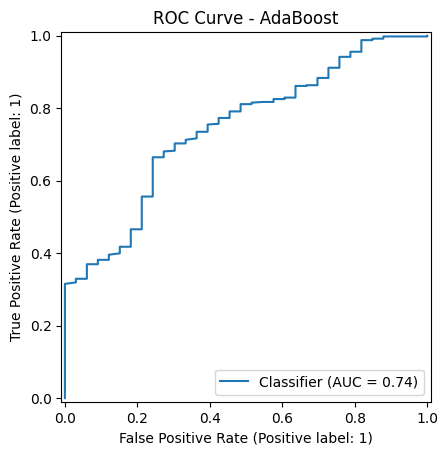

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, ConfusionMatrixDisplay

# Evaluate models
for model_name, model in best_models.items():
    print(f"\nEvaluating {model_name}...")

    # Predict and calculate probabilities
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"

    print(f"Accuracy: {acc * 100:.2f}%")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"ROC-AUC: {auc}")

    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    # ROC Curve
    if y_prob is not None:
        RocCurveDisplay.from_predictions(y_test, y_prob)
        plt.title(f"ROC Curve - {model_name}")
        plt.show()


In [6]:
simulation_input = pd.DataFrame({
    "Experience(Years)": [5, 15, 25],
    "Fee(PKR)": [1000, 3000, 5000],
    "Total_Reviews": [50, 500, 1200],
    "Wait Time(mins)": [10, 15, 20],
    "Avg Time to Patients(mins)": [10, 14, 19]
})

for model_name, model in best_models.items():
    print(f"\nSimulating with {model_name}...")
    predictions = model.predict(simulation_input)
    print(f"Predictions: {predictions} (1 = High Satisfaction, 0 = Low Satisfaction)")



Simulating with LogisticRegression...
Predictions: [0 0 0] (1 = High Satisfaction, 0 = Low Satisfaction)

Simulating with RandomForest...
Predictions: [0 0 0] (1 = High Satisfaction, 0 = Low Satisfaction)

Simulating with XGBoost...
Predictions: [0 0 0] (1 = High Satisfaction, 0 = Low Satisfaction)

Simulating with SVM...
Predictions: [1 1 1] (1 = High Satisfaction, 0 = Low Satisfaction)

Simulating with KNN...
Predictions: [0 0 0] (1 = High Satisfaction, 0 = Low Satisfaction)

Simulating with DecisionTree...
Predictions: [1 1 1] (1 = High Satisfaction, 0 = Low Satisfaction)

Simulating with NaiveBayes...
Predictions: [0 0 0] (1 = High Satisfaction, 0 = Low Satisfaction)

Simulating with AdaBoost...
Predictions: [0 0 0] (1 = High Satisfaction, 0 = Low Satisfaction)


In [ ]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split

# Split the dataset for Lazy Predict
X_train_lazy, X_test_lazy, y_train_lazy, y_test_lazy = train_test_split(X, y, test_size=0.2, random_state=42)

lazy_clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

import os
os.environ["TQDM_NOTEBOOK"] = "false"

models, predictions = lazy_clf.fit(X_train_lazy, X_test_lazy, y_train_lazy, y_test_lazy)

print(models)

models.to_csv('./dataset/lazy_predict_results.csv', index=False)
print("\nLazy Predict results saved to 'lazy_predict_results.csv'.")


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],          # Number of trees
    'max_depth': [None, 10, 20, 30],         # Maximum depth of trees
    'min_samples_split': [2, 5, 10],         # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]            # Minimum samples at a leaf node
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters and model
best_rf_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate the best model on the test set
y_pred = best_rf_model.predict(X_test)

# Calculate evaluation metrics
print("\nTest Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy: 0.9363507779349364

Test Set Evaluation:
Accuracy: 94.16
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.12      0.21        33
           1       0.94      1.00      0.97       498

    accuracy                           0.94       531
   macro avg       0.81      0.56      0.59       531
weighted avg       0.93      0.94      0.92       531

Confusion Matrix:
[[  4  29]
 [  2 496]]
